3.1 MNIST

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)


c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [100]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [10]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

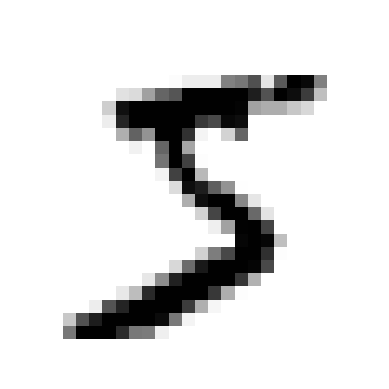

In [13]:
some_digit = X.to_numpy()[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap= 'binary')
plt.axis("off")
plt.show()

In [14]:
y[0]

'5'

In [17]:
y = y.astype(np.uint8)

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

3.2 이진 분류기 훈련(두 개의 클래스만 분류)

In [19]:
y_train_5 = (y_train == 5) # 5는 True, 나머지는 False
y_test_5 = (y_test == 5)

In [24]:
sgd_clf = SGDClassifier(random_state=42) #SGD: 확률적 경사 하강법
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [25]:
sgd_clf.predict([some_digit])

c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

3.3 성능 측정

3.3.1 교차 검증을 사용한 정확도 측정

In [28]:
#skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

#for train_index, test_index in skfolds.split(X_train, y_train_5):
    #clone_clf = clone(sgd_clf)
    #X_train_folds = X_train[train_index]
    #y_train_folds = y_train_5[train_index]
    #X_test_fold = X_train[test_index]
    #y_test_fold = y_train[test_index]
    
    #clone_clf.fit(X_train_folds, y_train_folds)
    #predictions = clone_clf.predict(X_test_fold)
    #n_correct = sum(predictions == y_test_fold)
    #print(n_correct/len(predictions))

In [30]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [32]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)

In [33]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [36]:
predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

3.3.2 오차 행렬

In [38]:
confusion_matrix(y_train_5, predictions)
#첫 번째 행은 5가 아닌 이미지에 대해서 53892개는 5가 아니라고 분류, 687갸느 5가 맞다고 분류
#두 번째 행은 5가 맞는 이미지에 대해서 1891개는 5가 아니라고 분류, 3530개는 5가 맞다고 분류

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [39]:
y_train_perfect_predictions = y_train_5 #분류기가 완벽할 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

3.3.3 정밀도와 재현율

In [ ]:
#정밀도 : 진짜 양성 / (진짜 양성 + 거짓 양성)
#재현율 : 진짜 양성 / (진짜 양성 + 거짓 음성)

In [41]:
precision_score(y_train_5, predictions) #정밀도

0.8370879772350012

In [42]:
recall_score(y_train_5, predictions) #재현율

0.6511713705958311

In [45]:
f1_score(y_train_5, predictions) #f1_score: 정밀도와 재현율의 조화 평균으로 2개의 점수를 한 번에 보여줌

0.7325171197343846

3.3.4 정밀도/재현율 트레이드오프

In [46]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [47]:
threshold = 0

In [48]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [49]:
thershold = 8000
y_some_digit_pred = (y_scores > thershold)
y_some_digit_pred

array([False])

In [50]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [56]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) 

In [54]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g--", label="재현율")
    [...]

<function matplotlib.pyplot.show(close=None, block=None)>

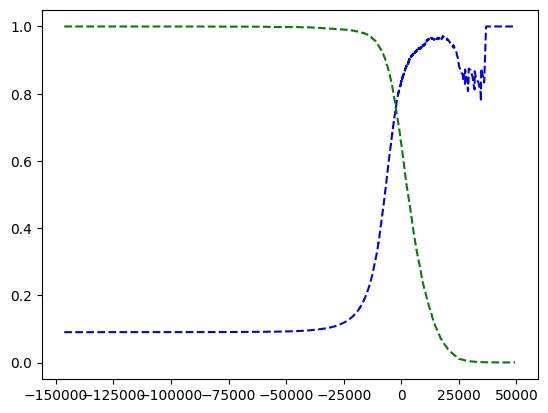

In [57]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show

In [59]:
threshold_90_precision = thresholds[np.argmax(precisions >=0.90)]

In [60]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [61]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

3.3.5 ROC 곡선(1- 진짜 음성 비율)

In [66]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')

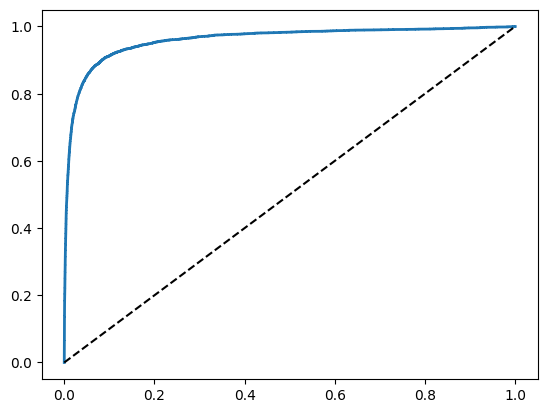

In [67]:
plot_roc_curve(fpr,tpr)
plt.show()

In [69]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [71]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=2, method="predict_proba")

In [72]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

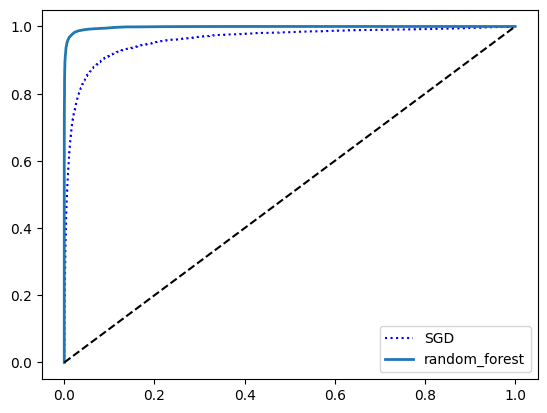

In [75]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random_forest")
plt.legend(loc="lower right")
plt.show()

In [76]:
roc_auc_score(y_train_5, y_scores_forest)

0.9980758705129729

3.4 다중 분류

In [78]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])


c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [79]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores
#가장 높은 점수를 가진 클래스를 선택 >> 아래에서는 5번 클래스가 제일 높으므로 5라고 판단

c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [83]:
#np.argmax(some_digit_scores)
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [85]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])


c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SVC was fitte

array([5], dtype=uint8)

In [86]:
len(ovr_clf.estimators_)

10

In [90]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])


c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [91]:
sgd_clf.decision_function([some_digit])

c:\Users\JW\Desktop\khl\venv\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [93]:
cross_val_score(sgd_clf,X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [95]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring ='accuracy')


array([0.8983, 0.891 , 0.9018])

3.5 에러 분석

In [106]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [107]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

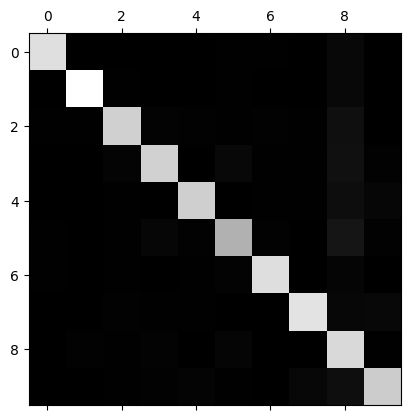

In [108]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [110]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

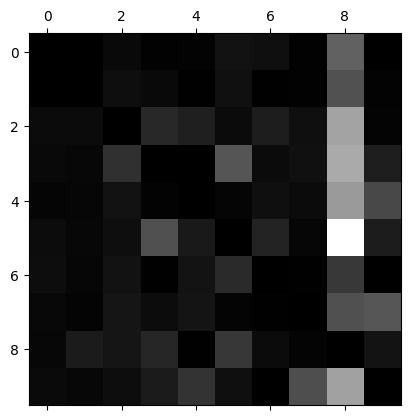

In [111]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [119]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

AttributeError: 'str' object has no attribute 'reshape'

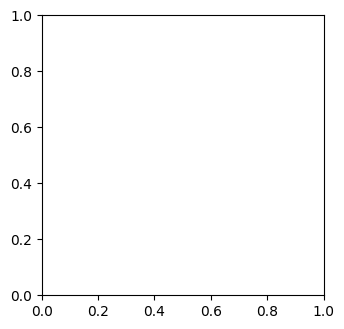

In [120]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()